# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator


import math

# Simulator

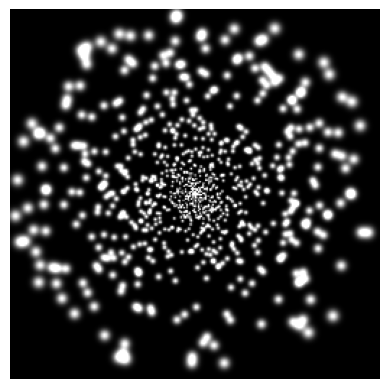

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [3]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

Loss = 0.0028: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.80iter/s]


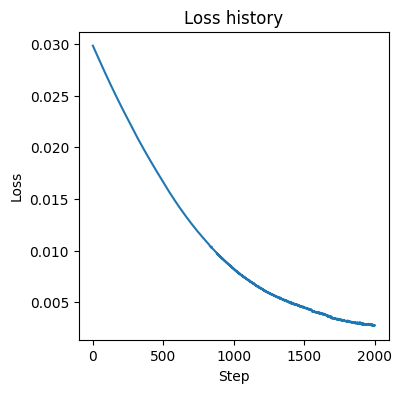

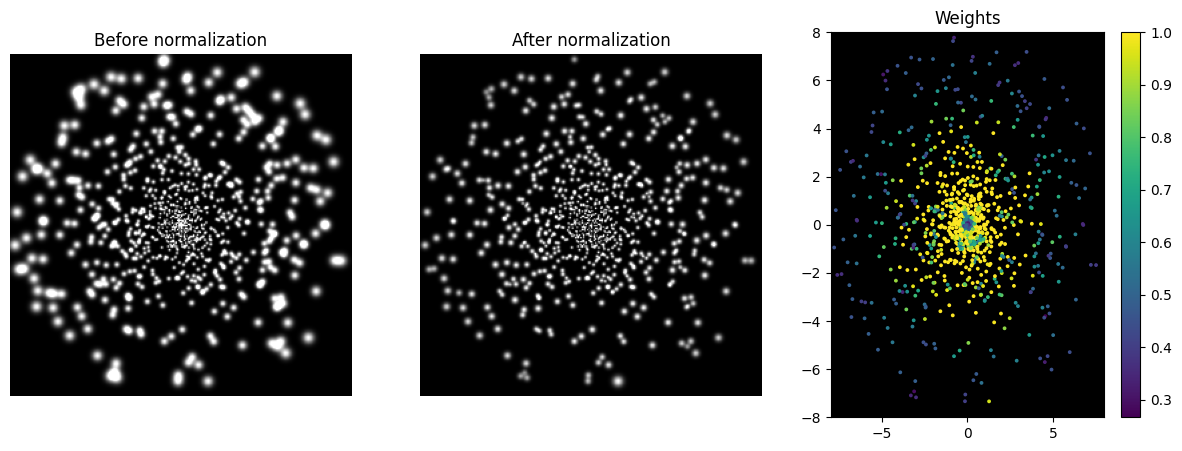

Percentage of amplitude: 76.29%


In [4]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [5]:
from phosphene.density import VisualFieldMapper

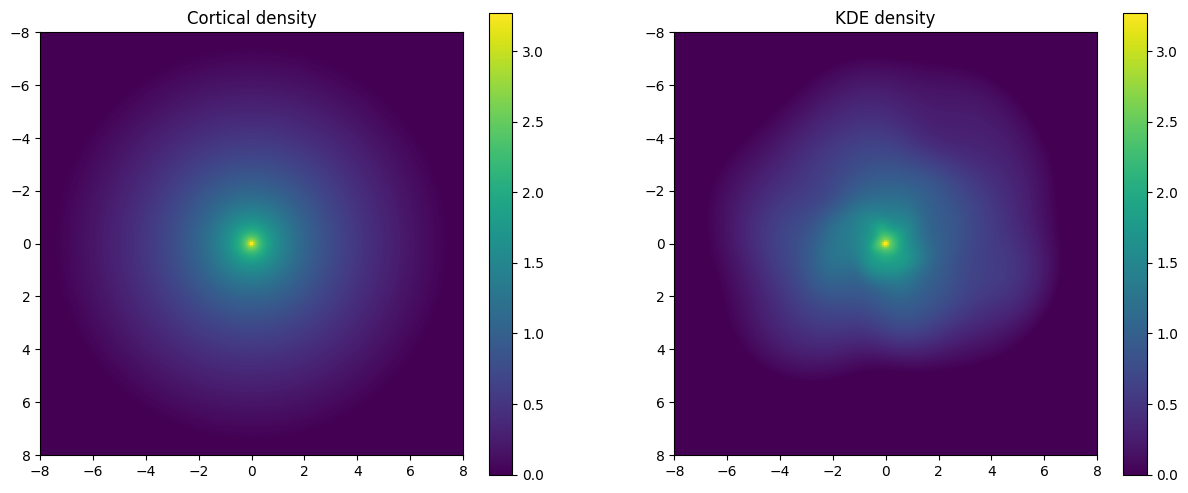

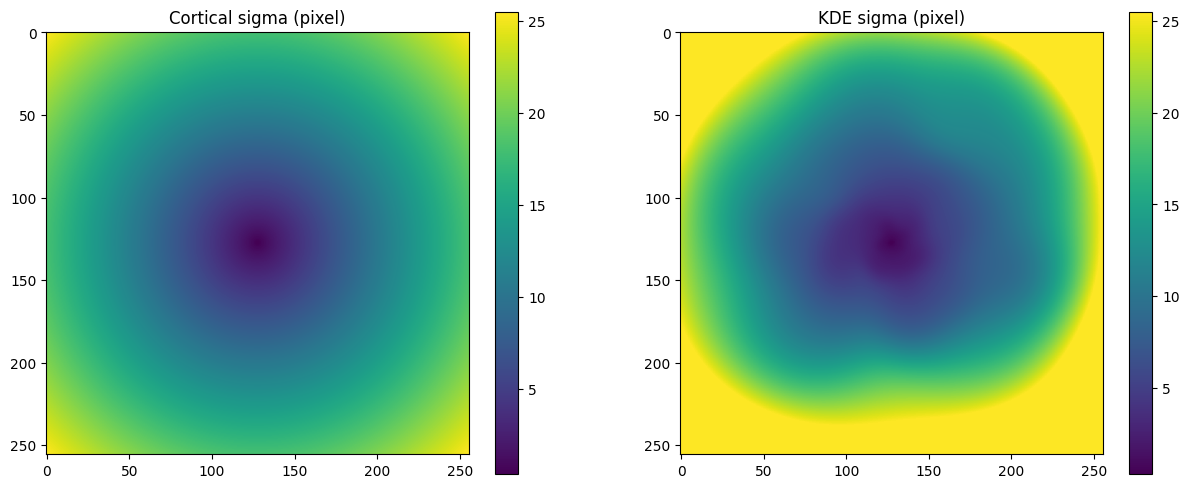

In [6]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=16, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Image processing for Phosphene Vision

In [7]:
from data.local_datasets import LaPaDataset
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation
import yaml

def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked


cfg = load_config('../config/256x256_LaPa.yaml')
LaPa_dataset = LaPaDataset(cfg)

In [8]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


# Dilation is used for the reg-loss on the phosphene image: phosphenes do not have to map 1 on 1, small offset is allowed.
def dilation5x5(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[[0., 0., 1., 0., 0.],
                              [0., 1., 1., 1., 0.],
                              [1., 1., 1., 1., 1.],
                              [0., 1., 1., 1., 0.],
                              [0., 0., 1., 0., 0.]]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [9]:
sigma_map_tensor = torch.tensor(sigma_kde_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

UnifiedInputModulation()

We are going to compare 3 types of image processing:
- Input image thresholding
- Ground truth outlines
- LoG filtered

We will calculate the SSIM between the input and the phosphene images.
We will also calculate the SSIM between the phosphene images and the filtered images.

In [10]:
image_processing_dict = {}

threshold = params['thresholding']['rheobase']

for image_index, batch in enumerate(LaPa_dataset):
    image = batch['image']
    contour = batch['contour']

    # dilate the contour 5x5
    contour = dilation5x5(contour.unsqueeze(0)).squeeze(0)
    # contour = modified_cdf_normalization(contour, 1)

    LoG = layer(image.unsqueeze(0)).clip(0, None).squeeze(0)
    LoG = (LoG - LoG.min()) / (LoG.max() - LoG.min())

    grayscale = image.mean(dim=0)

    # 1) Grayscale
    simulator.reset()
    grayscale_electrode = simulator.sample_stimulus(grayscale, rescale=True)
    grayscale_electrode = robust_percentile_normalization(grayscale_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    grayscale_electrode = grayscale_electrode * stim_weights
    grayscale_phosphenes = simulator(grayscale_electrode)

    # 2) Contour
    simulator.reset()
    contour_electrode = simulator.sample_stimulus(contour, rescale=True)
    contour_electrode = robust_percentile_normalization(contour_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    contour_electrode = contour_electrode * stim_weights
    contour_phosphenes = simulator(contour_electrode)

    # 3) LoG response
    simulator.reset()
    LoG_electrode = simulator.sample_stimulus(LoG.max(0).values, rescale=True)
    LoG_electrode = robust_percentile_normalization(LoG_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    LoG_electrode = LoG_electrode * stim_weights
    LoG_phosphenes = simulator(LoG_electrode)


    image_processing_dict[image_index] = {
    'image': image,
    'grayscale': {
        'stim': grayscale,
        'phosphenes': grayscale_phosphenes
    },
    'contour': {
        'stim': contour,
        'phosphenes': contour_phosphenes
    },
    'LoG_response': {
        'stim': LoG,
        'phosphenes': LoG_phosphenes
    }
    }
    
    if image_index == 5:
        break

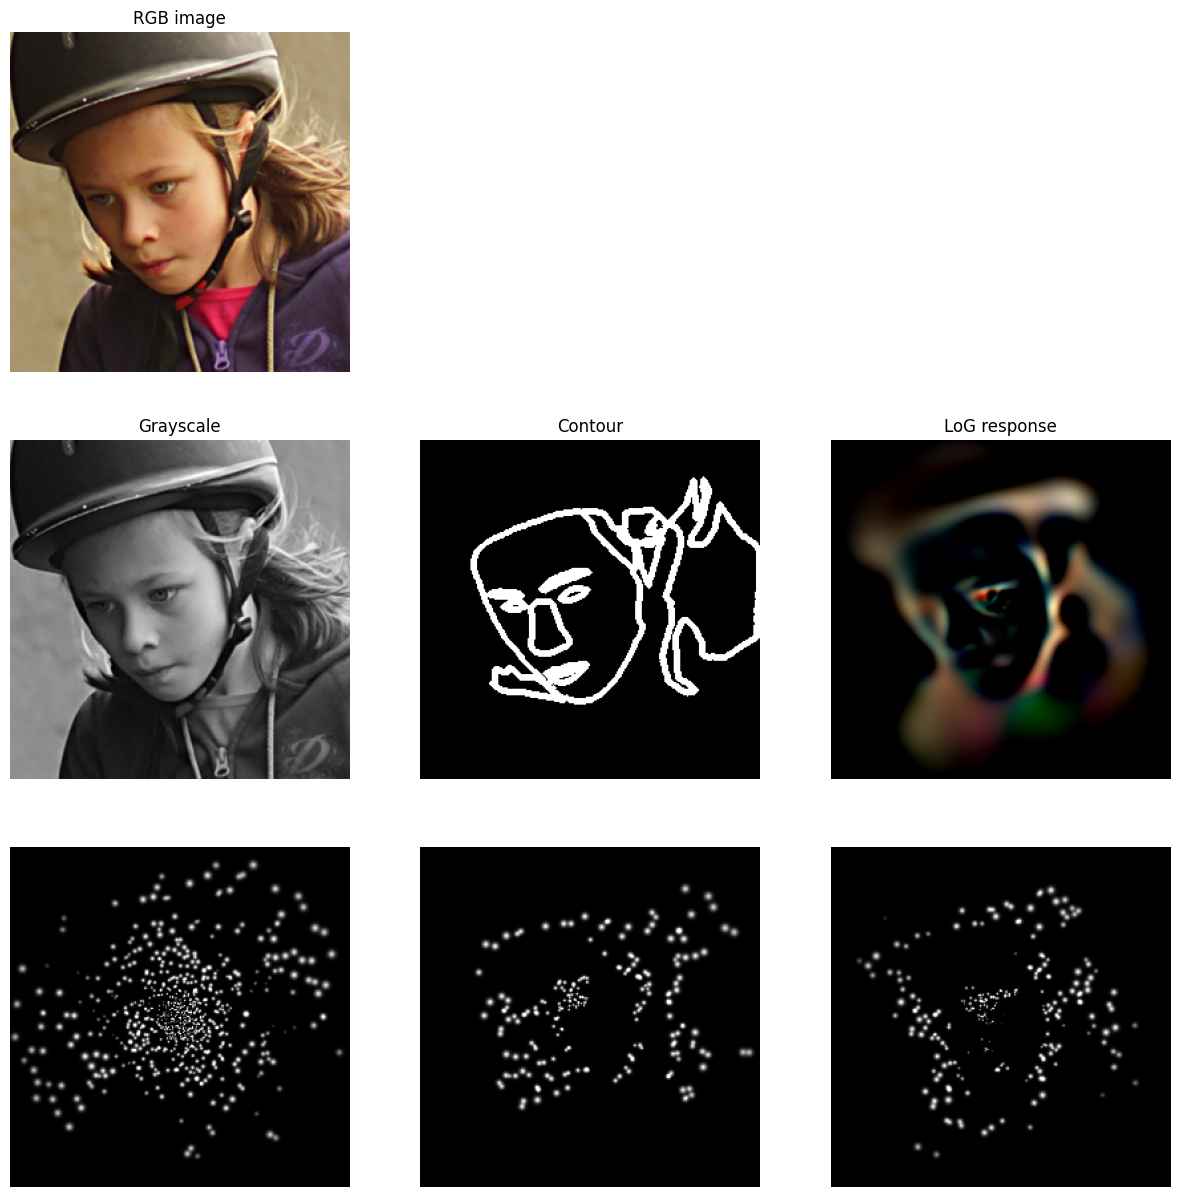

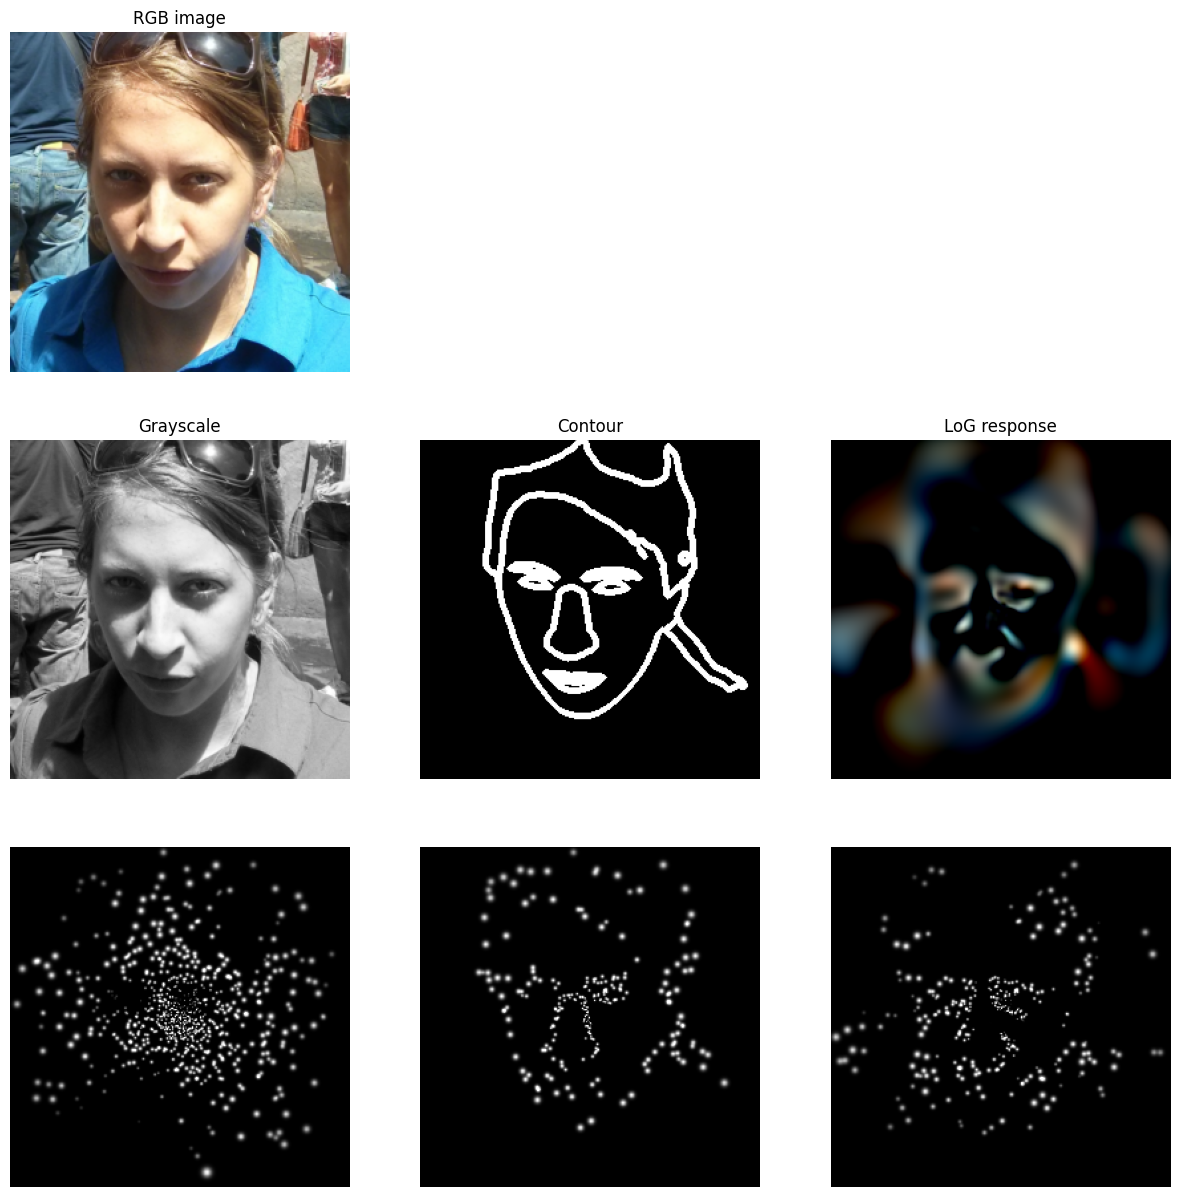

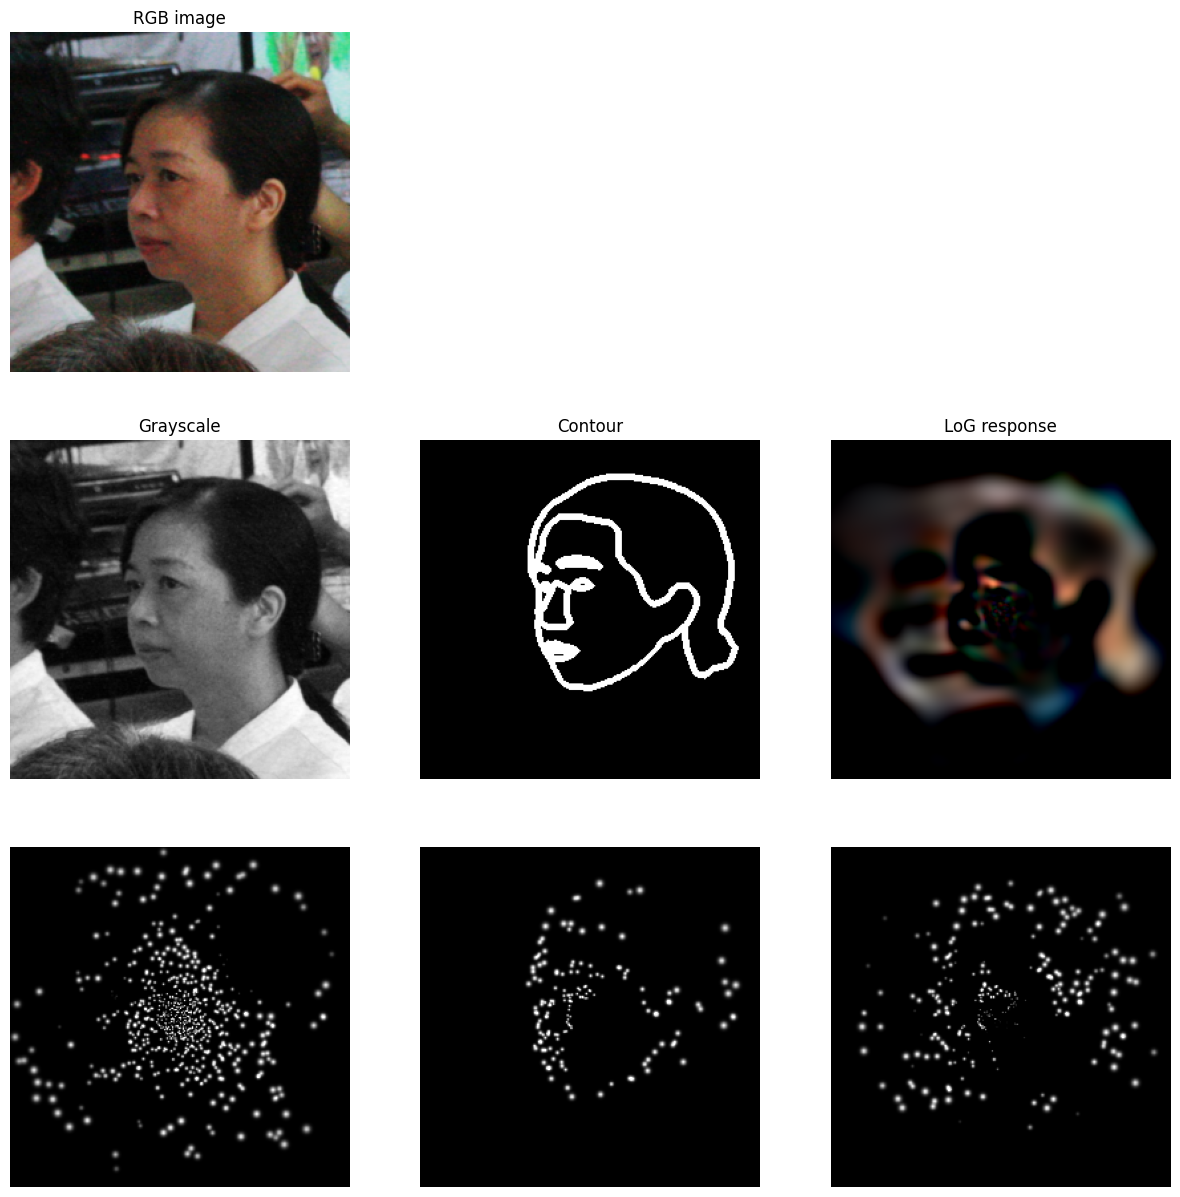

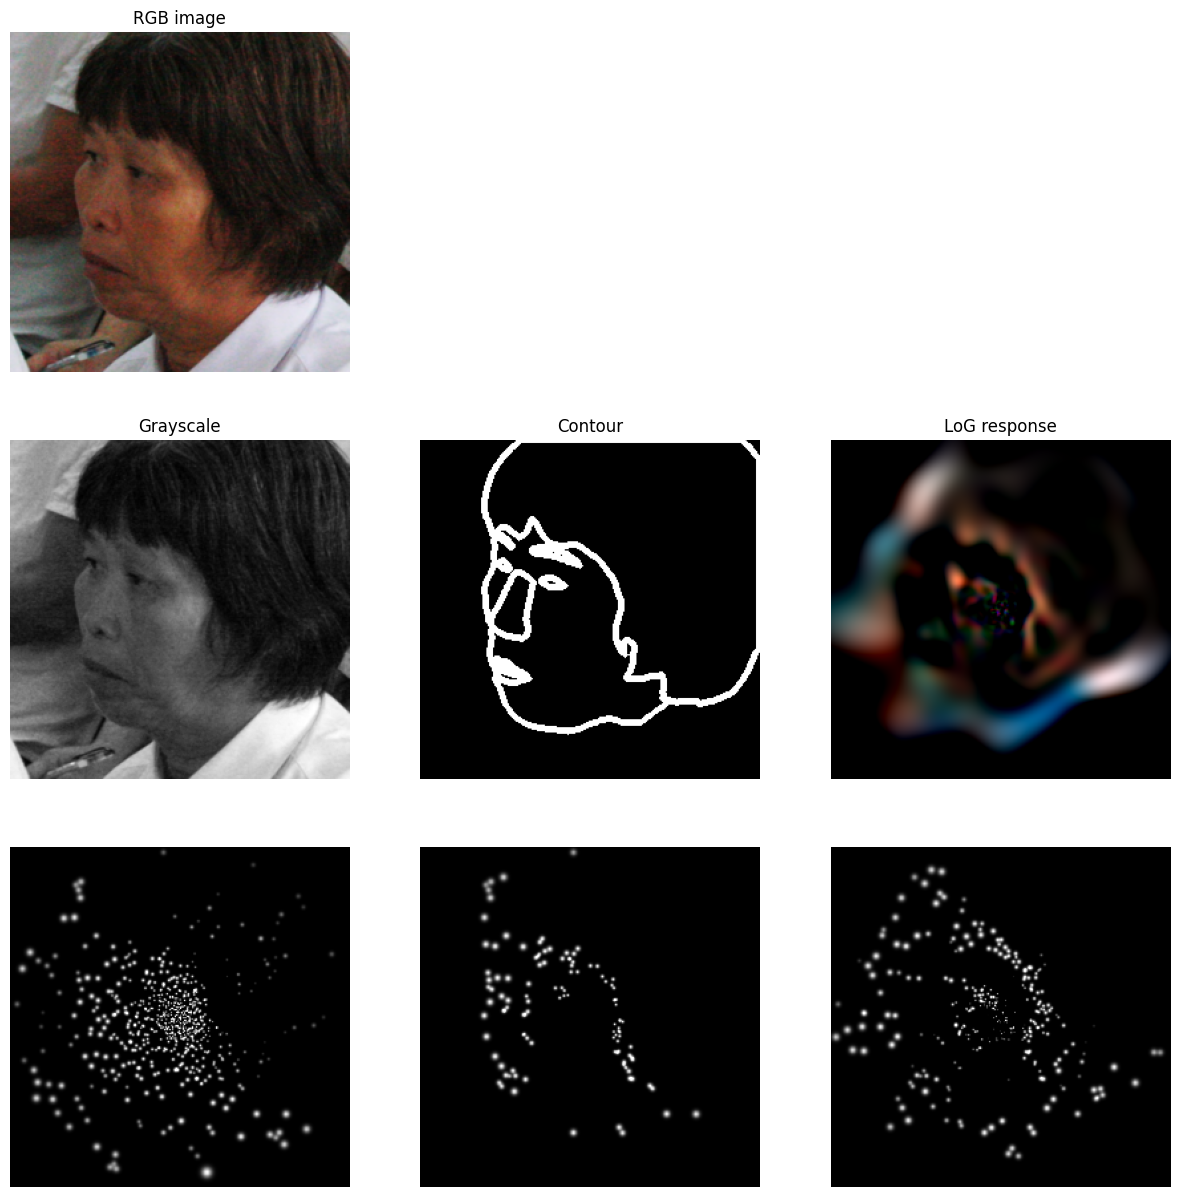

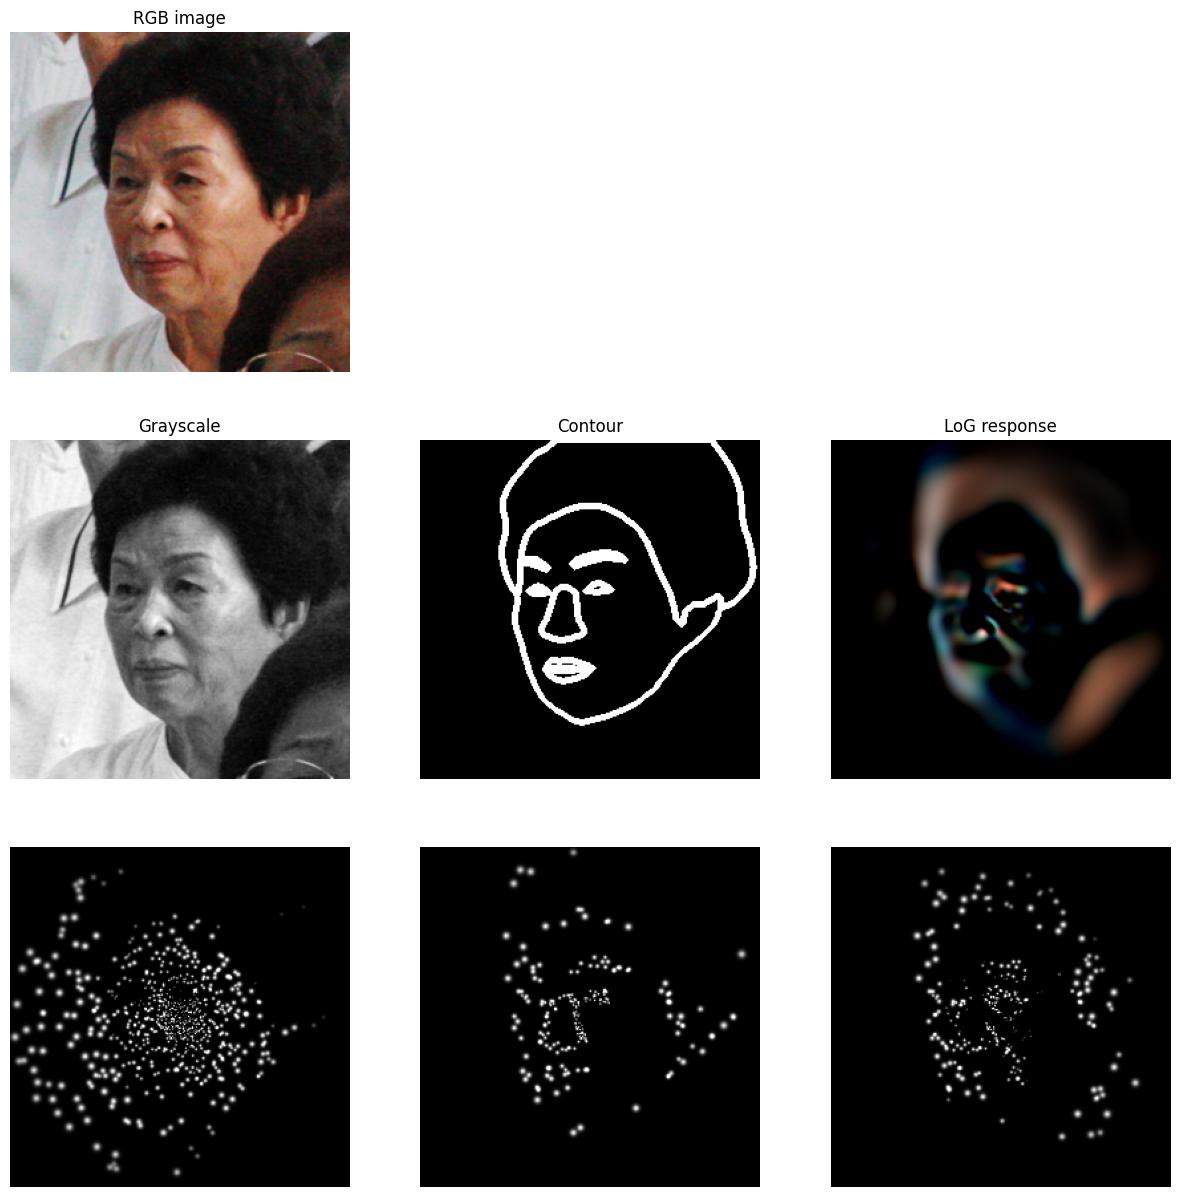

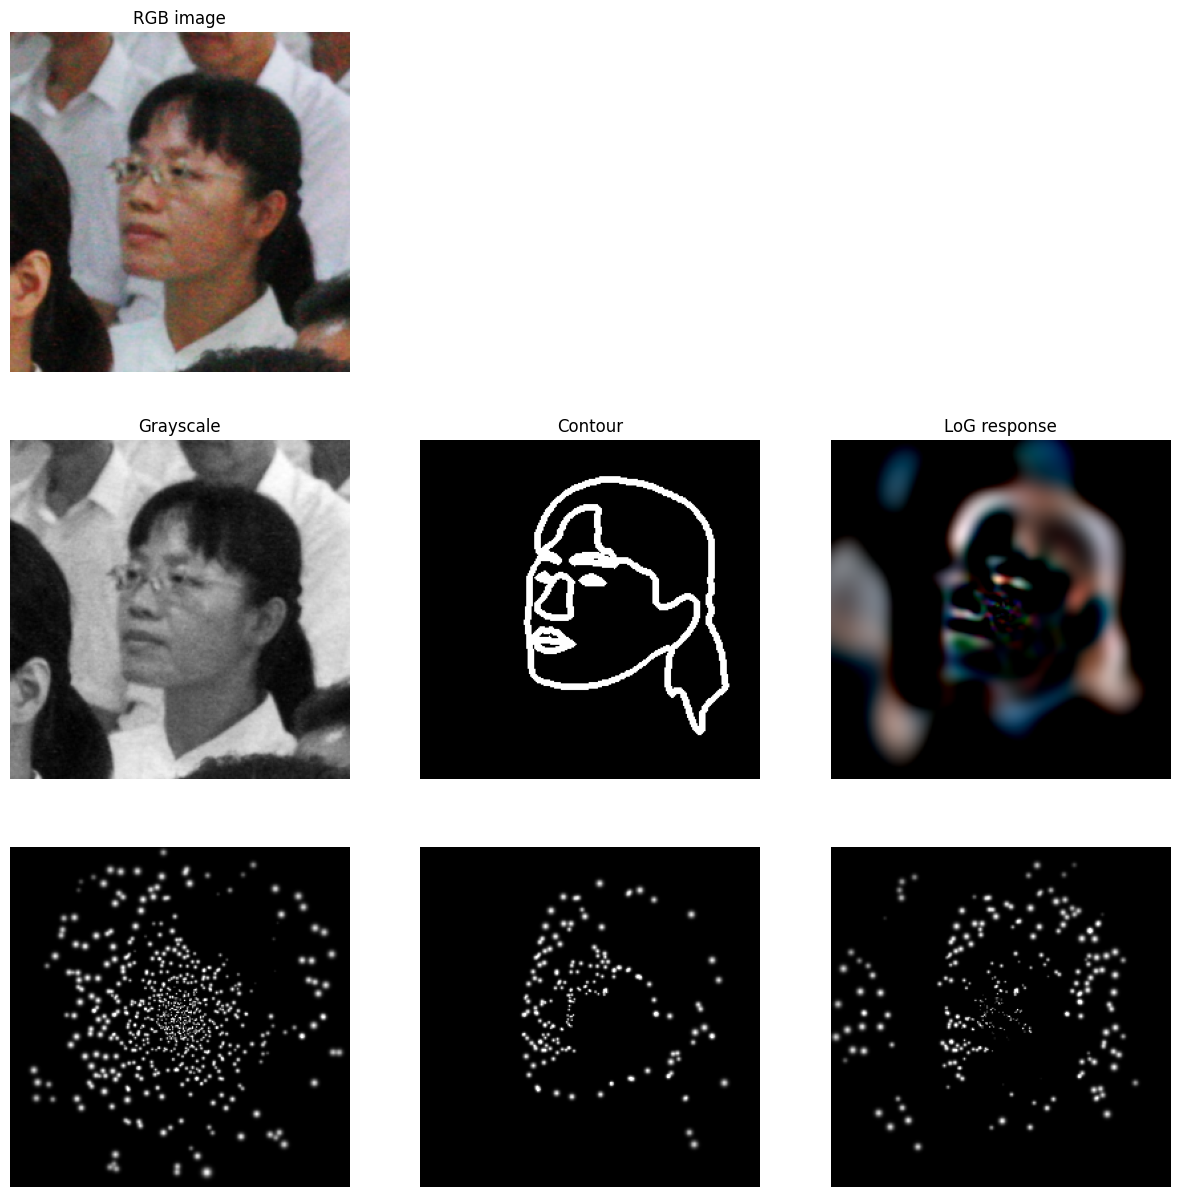

In [11]:
for image_index in list(image_processing_dict.keys()):
    # plot RGB image, grayscale, contour, LoG, and phosphenes
    image = image_processing_dict[image_index]['image']
    grayscale = image_processing_dict[image_index]['grayscale']['stim']
    contour = image_processing_dict[image_index]['contour']['stim']
    LoG = image_processing_dict[image_index]['LoG_response']['stim']
    phos_grayscale = image_processing_dict[image_index]['grayscale']['phosphenes']
    phos_contour = image_processing_dict[image_index]['contour']['phosphenes']
    phos_LoG = image_processing_dict[image_index]['LoG_response']['phosphenes']

    plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('RGB image')

    plt.subplot(3, 3, 4)
    plt.imshow(grayscale.cpu(), cmap='gray')
    plt.axis('off')
    plt.title('Grayscale')

    plt.subplot(3, 3, 5)
    plt.imshow(contour.cpu().squeeze(0), cmap='gray')
    plt.axis('off')
    plt.title('Contour')

    plt.subplot(3, 3, 6)
    plt.imshow(LoG.permute(1,2,0).cpu(), cmap='gray')
    plt.axis('off')
    plt.title('LoG response')

    plt.subplot(3, 3, 7)
    plt.imshow(phos_grayscale.cpu(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 3, 8)
    plt.imshow(phos_contour.cpu(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 3, 9)
    plt.imshow(phos_LoG.cpu(), cmap='gray')
    plt.axis('off')
    plt.show()

# Evaluate

### Sliced Wasserstein Distance (SWD) for Evaluating Sparse Phosphene Images

The sliced Wasserstein distance (SWD) is an efficient alternative to the full Earth Mover’s Distance (EMD) that measures the dissimilarity between two probability distributions. In our application, we treat an image as a probability distribution by normalizing its pixel intensities so that the sum over all pixels equals 1. That is, given an image $I(x,y)$, we compute the normalized distribution as $P(x,y)=\frac{I(x,y)}{\sum_{x,y}I(x,y)}$. In this form, each pixel’s intensity represents the “mass” or probability at that location.

Instead of comparing images on a pixel-by-pixel basis, the SWD works by projecting these high-dimensional distributions onto many one-dimensional subspaces. For each random direction $\theta$, we project the pixel coordinates onto that line, computing the projected values $P_{\theta}(x,y)=\langle (x,y), \theta \rangle$. Then, we compute the 1D Wasserstein distance between the projected distributions. Finally, we average these distances over a number of random projections to obtain the SWD.

Mathematically, if we have two probability distributions $\mu$ and $\nu$, the sliced Wasserstein distance is defined as

$$
SW_p(\mu, \nu)=\left( \frac{1}{L}\sum_{l=1}^{L}W_p^p(P_{\theta_l\#}\mu,P_{\theta_l\#}\nu)\right)^{\frac{1}{p}},
$$

where $L$ is the number of random directions, $P_{\theta_l\#}\mu$ denotes the projection of $\mu$ onto the one-dimensional subspace defined by $\theta_l$, and $W_p$ is the 1D Wasserstein distance (which is efficiently computed by simply sorting the projected values).

This method is particularly well-suited for our sparse phosphene images because it does not depend solely on the histogram of intensities but also captures the spatial layout of the activated (bright) pixels. Even if two images have a similar overall intensity distribution, differences in the locations of the activations will be reflected in a higher SWD. In our experiments, a lower SWD indicates that the spatial distribution of activation in the phosphene image is closer to that of the target image.

In [12]:
from scipy.stats import wasserstein_distance

def compute_sliced_wasserstein_distance(image1, image2, num_projections=100):
    """
    Compute the sliced Wasserstein distance (SWD) between two 2D images.
    Both images should be 2D numpy arrays that are non-negative and normalized to sum to 1.
    
    Args:
      image1, image2: 2D numpy arrays of the same shape.
      num_projections: int, number of random directions to use.
    
    Returns:
      swd: float, the computed sliced Wasserstein distance.
    """
    # Flatten images to 1D arrays but we need to keep spatial coordinates.
    H, W = image1.shape
    
    # Create grid of coordinates for each pixel.
    x_coords, y_coords = np.meshgrid(np.arange(W), np.arange(H))
    coords = np.stack([x_coords.flatten(), y_coords.flatten()], axis=1)  # shape: (H*W, 2)
    
    # Flatten the image intensities.
    a = image1.flatten()
    b = image2.flatten()
    
    swd_sum = 0.0
    for _ in range(num_projections):
        # Generate a random unit vector in 2D.
        theta = np.random.uniform(0, 2 * np.pi)
        direction = np.array([np.cos(theta), np.sin(theta)])
        
        # Project coordinates onto the direction.
        proj = coords.dot(direction)  # shape: (H*W,)
        
        # Sort the projections and associated weights.
        idx = np.argsort(proj)
        proj_sorted = proj[idx]
        a_sorted = a[idx]
        b_sorted = b[idx]
        
        # Compute 1D Wasserstein distance for this projection.
        wd = wasserstein_distance(proj_sorted, proj_sorted, u_weights=a_sorted, v_weights=b_sorted)
        swd_sum += wd
        
    swd = swd_sum / num_projections
    return swd

# Example usage:
# Ensure your images are normalized. For example:
def normalize_image(image):
    image = np.maximum(image, 0).astype(np.float32)
    return image / (np.sum(image) + 1e-8)

In [13]:
image_index = 5

grayscale_np = normalize_image(image_processing_dict[image_index]['grayscale']['stim'].cpu().numpy())
contour_np = normalize_image(image_processing_dict[image_index]['contour']['stim'].squeeze(0).cpu().numpy())
log_np = normalize_image(image_processing_dict[image_index]['LoG_response']['stim'].max(0).values.cpu().numpy())

grayscale_phosphene_np = normalize_image(image_processing_dict[image_index]['grayscale']['phosphenes'].cpu().numpy())
contour_phosphene_np = normalize_image(image_processing_dict[image_index]['contour']['phosphenes'].cpu().numpy())
log_phosphene_np = normalize_image(image_processing_dict[image_index]['LoG_response']['phosphenes'].cpu().numpy())

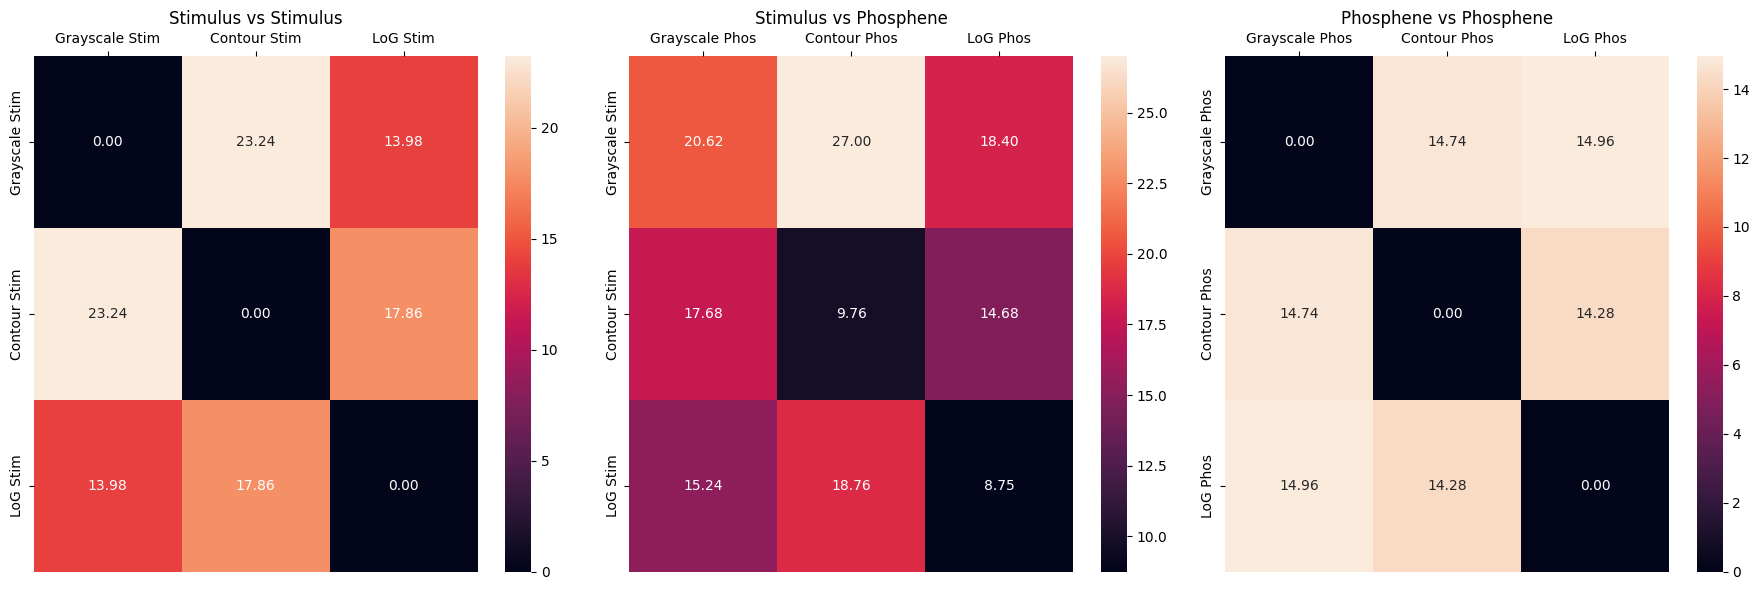

In [14]:
import seaborn as sns

# Labels for the conditions
labels_stim = ["Grayscale Stim", "Contour Stim", "LoG Stim"]
labels_phos = ["Grayscale Phos", "Contour Phos", "LoG Phos"]

# Assume these numpy arrays have been computed and normalized:
# Stimuli: grayscale_np, contour_np, log_np
# Phosphenes: grayscale_phosphene_np, contour_phosphene_np, LoG_phosphene_np
# And compute_sliced_wasserstein_distance(image1, image2, num_projections) is defined.
num_projections = 50
# 1. Stimulus vs Stimulus (symmetric)
stim_images = [grayscale_np, contour_np, log_np]
stim_stim_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(i, 3):
        swd_val = compute_sliced_wasserstein_distance(stim_images[i], stim_images[j], num_projections=num_projections)
        stim_stim_matrix[i, j] = swd_val
        stim_stim_matrix[j, i] = swd_val  # symmetric

# 2. Phosphene vs Phosphene (symmetric)
phos_images = [grayscale_phosphene_np, contour_phosphene_np, log_phosphene_np]
phos_phos_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(i, 3):
        swd_val = compute_sliced_wasserstein_distance(phos_images[i], phos_images[j], num_projections=num_projections)
        phos_phos_matrix[i, j] = swd_val
        phos_phos_matrix[j, i] = swd_val

# 3. Stimulus vs Phosphene (non-symmetric grouping: rows=stim, columns=phos)
stim_phos_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        stim_phos_matrix[i, j] = compute_sliced_wasserstein_distance(stim_images[i], phos_images[j], num_projections=num_projections)

# Now plot three separate heatmaps.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Stimulus vs Stimulus heatmap
sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
            xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0])
axes[0].set_title("Stimulus vs Stimulus")
axes[0].xaxis.tick_top()

# Plot Stimulus vs Phosphene heatmap (full matrix)
sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
            xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1])
axes[1].set_title("Stimulus vs Phosphene")
axes[1].xaxis.tick_top()

# Plot Phosphene vs Phosphene heatmap
sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
            xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2])
axes[2].set_title("Phosphene vs Phosphene")
axes[2].xaxis.tick_top()

plt.tight_layout()
plt.show()

### Gist descriptors

In [15]:
import torch.nn.functional as F
import math

def create_gabor_kernel(kernel_size, frequency, theta, sigma=None, phase=0, gamma=1.0, device='cpu'):
    """
    Create a Gabor kernel in PyTorch.
    
    Parameters:
      kernel_size : int
          The size of the kernel (must be odd).
      frequency : float
          The frequency (1/λ) of the sinusoid.
      theta : float
          The orientation of the Gabor kernel (in radians).
      sigma : float, optional
          Standard deviation of the Gaussian envelope; if None, set to kernel_size/6.
      phase : float, optional
          The phase offset of the sinusoid (default=0).
      gamma : float, optional
          The spatial aspect ratio (default=1.0).
      device : str
          The device on which to create the kernel.
    
    Returns:
      kernel : torch.Tensor of shape [kernel_size, kernel_size]
    """
    if sigma is None:
        sigma = kernel_size / 6.0  # heuristic
    # Create coordinate grid centered at 0.
    radius = kernel_size // 2
    y, x = torch.meshgrid(torch.arange(-radius, radius+1, device=device).float(),
                          torch.arange(-radius, radius+1, device=device).float(),
                          indexing='ij')
    # Rotate the coordinates
    x_prime = x * math.cos(theta) + y * math.sin(theta)
    y_prime = -x * math.sin(theta) + y * math.cos(theta)
    # Gabor kernel formula (using cosine for the sinusoidal part)
    exp_factor = torch.exp(-(x_prime**2 + (gamma**2) * y_prime**2) / (2 * sigma**2))
    sinusoid = torch.cos(2 * math.pi * frequency * x_prime + phase)
    kernel = exp_factor * sinusoid
    # Normalize the kernel so that the sum of absolute values equals 1 (or sum to 1).
    kernel = kernel - kernel.mean()  # zero-mean (optional, sometimes desirable)
    kernel = kernel / (kernel.abs().sum() + 1e-8)
    return kernel

def compute_gist_parallel(image, orientations=12, scales=7, grid_size=(8, 8),
                          freq_min=0.01, freq_max=0.1, device='cuda', plot_response=False, plot_kernels=False):
    """
    Compute a gist descriptor for a 2D image in a parallel, GPU-accelerated manner.
    
    Parameters:
      image : 2D numpy array or torch.Tensor (assumed to be normalized to [0,1]).
      orientations : int, number of filter orientations.
      scales : int, number of filter scales (frequencies).
      grid_size : tuple of ints (e.g., (8,8)) specifying the number of spatial blocks.
      freq_min : float, minimum frequency for the Gabor filters.
      freq_max : float, maximum frequency for the Gabor filters.
      device : str, device to run on (e.g. 'cuda').
      
    Returns:
      gist_vector : 1D numpy array representing the gist descriptor.
    """
    # Ensure image is a torch tensor on the right device
    if not isinstance(image, torch.Tensor):
        image = torch.tensor(image, dtype=torch.float32, device=device)
    else:
        image = image.to(device=device, dtype=torch.float32)
    
    # Add batch and channel dimensions: shape becomes (1, 1, H, W)
    H, W = image.shape
    image = image.unsqueeze(0).unsqueeze(0)
    
    # Determine the frequencies (scales) using logarithmic spacing.
    frequencies = np.logspace(np.log10(freq_min), np.log10(freq_max), scales)
    
    # Generate a bank of Gabor kernels.
    kernels = []
    for freq in frequencies:
        for theta in np.linspace(0, np.pi, orientations, endpoint=False):
            # For larger kernels (lower frequencies) we may use a larger kernel size.
            # Here we use the given kernel_size from freq; you can adjust it as needed.
            # We choose the same kernel size for all kernels (it must be odd).
            # For instance, if low frequency requires a bigger kernel, set kernel_size accordingly.
            # You can parameterize this; here, as an example, we set kernel_size to 119 if freq is low,
            # and otherwise use a default value. For simplicity, we use a fixed kernel_size:
            kernel_size = 199
            # sigma based on frequency 
            sigma = 2 * math.sqrt(math.log(2)) / (math.pi * freq)
            kernel = create_gabor_kernel(kernel_size, frequency=freq, theta=theta, sigma=sigma, device=device)
            kernels.append(kernel)

    if plot_kernels:
        figsize = (orientations*1.2, scales*1.2)
        plt.figure(figsize=figsize)
        for i, kernel in enumerate(kernels):
            plt.subplot(scales, orientations, i+1)
            plt.imshow(kernel.cpu().detach().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()
    
    # Stack kernels into a tensor of shape (num_kernels, 1, kernel_size, kernel_size)
    kernel_bank = torch.stack(kernels, dim=0).unsqueeze(1)  # shape: [K, 1, k, k]
    num_kernels = kernel_bank.shape[0]
    
    # Use conv2d to convolve the image with all kernels in parallel.
    # Output shape: (1, num_kernels, H, W) if we use padding to keep the size.
    pad = kernel_bank.shape[-1] // 2
    responses = F.conv2d(image, kernel_bank, padding=pad)
    # Take absolute value of responses (as in the original descriptor computation)
    if plot_response:
        figsize = (orientations*1.2, scales*1.2)
        plt.figure(figsize=figsize)
        for i in range(num_kernels):
            plt.subplot(scales, orientations, i+1)
            plt.imshow(responses[0, i].cpu().detach().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()
    responses = torch.abs(responses)
    
    # Now pool the responses spatially into grid blocks.
    # Use adaptive average pooling to get output shape (1, num_kernels, grid_h, grid_w)
    grid_h, grid_w = grid_size
    pooled = F.adaptive_avg_pool2d(responses, output_size=(grid_h, grid_w))
    # Flatten the pooled responses: shape (num_kernels * grid_h * grid_w,)
    gist_vector = pooled.view(-1)
    return gist_vector

def euclidean(x, y):
    return torch.norm(x - y)

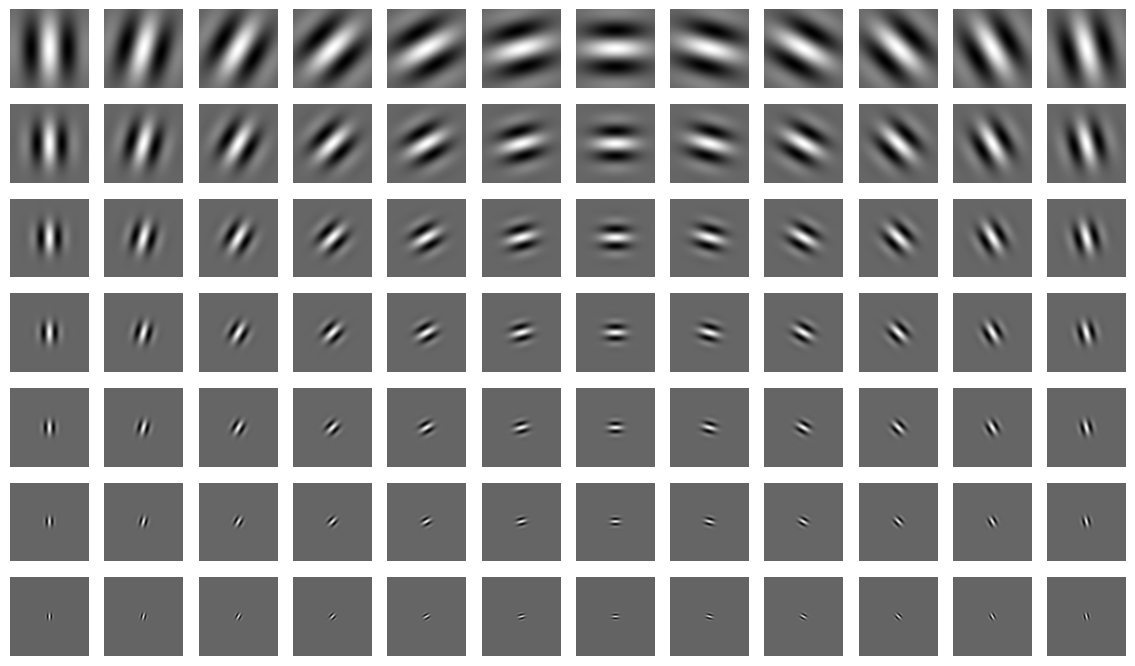

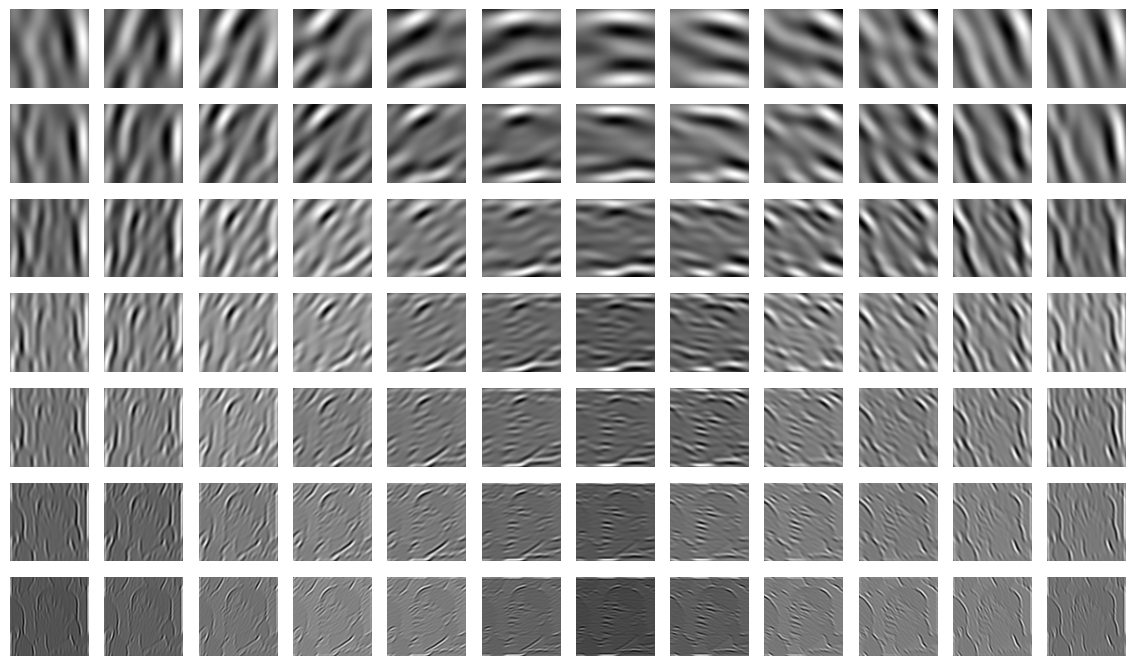

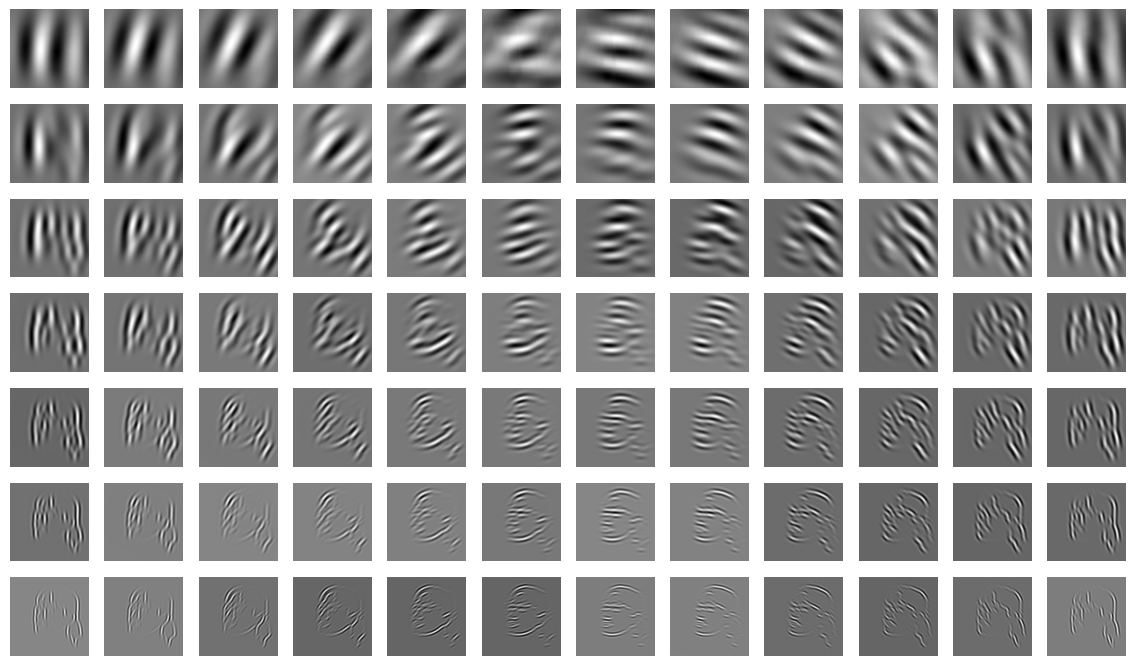

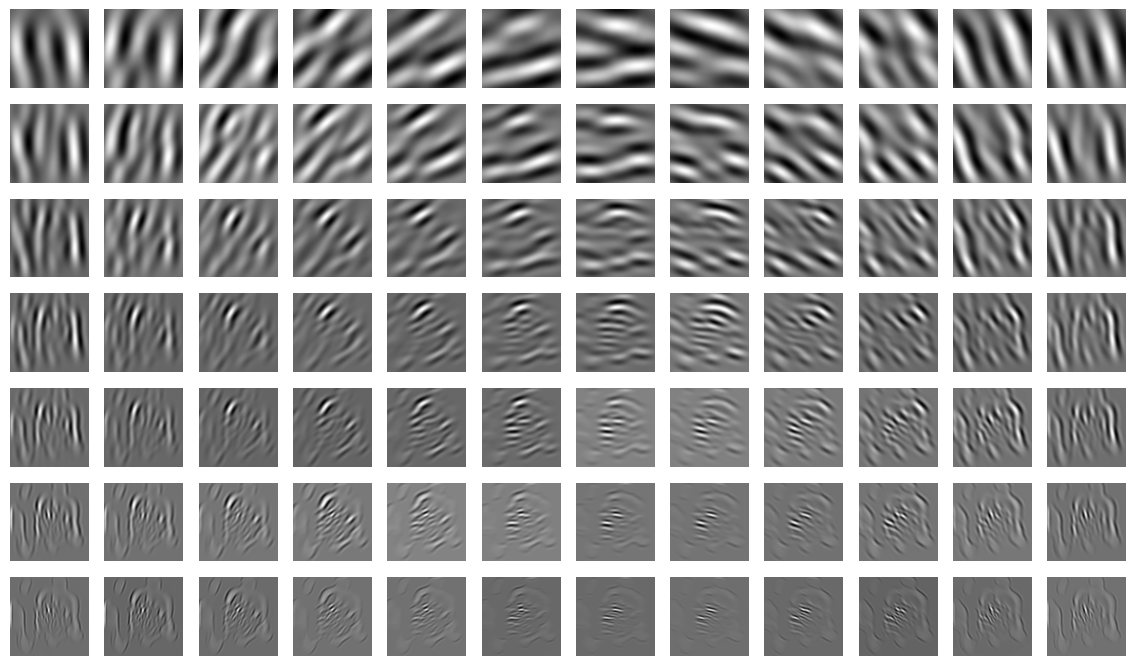

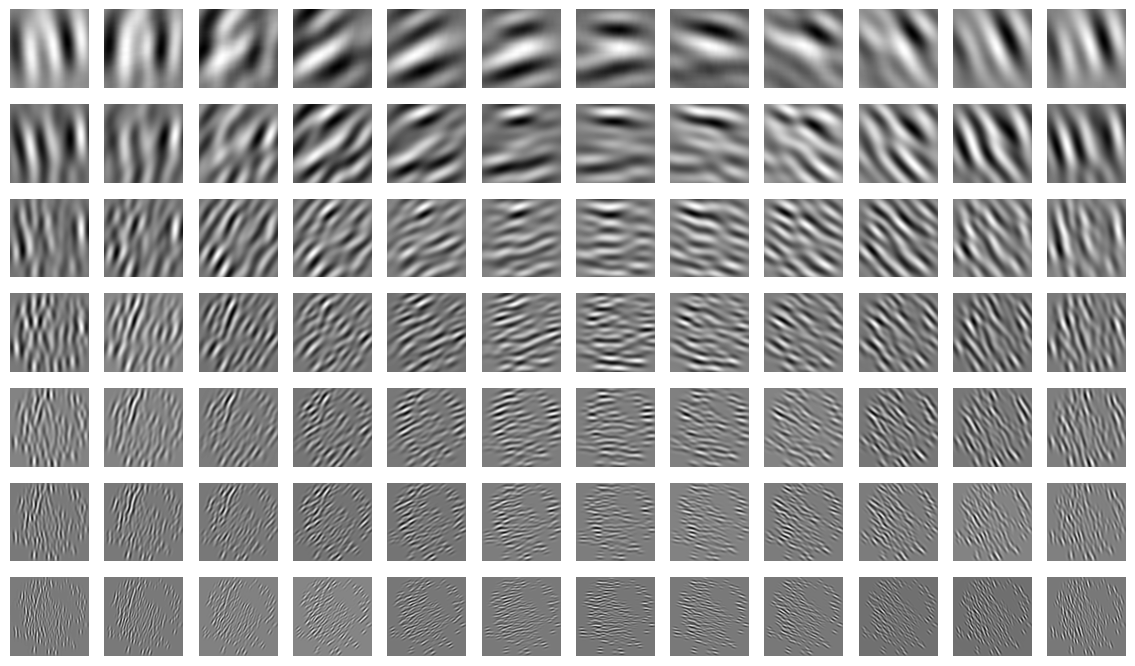

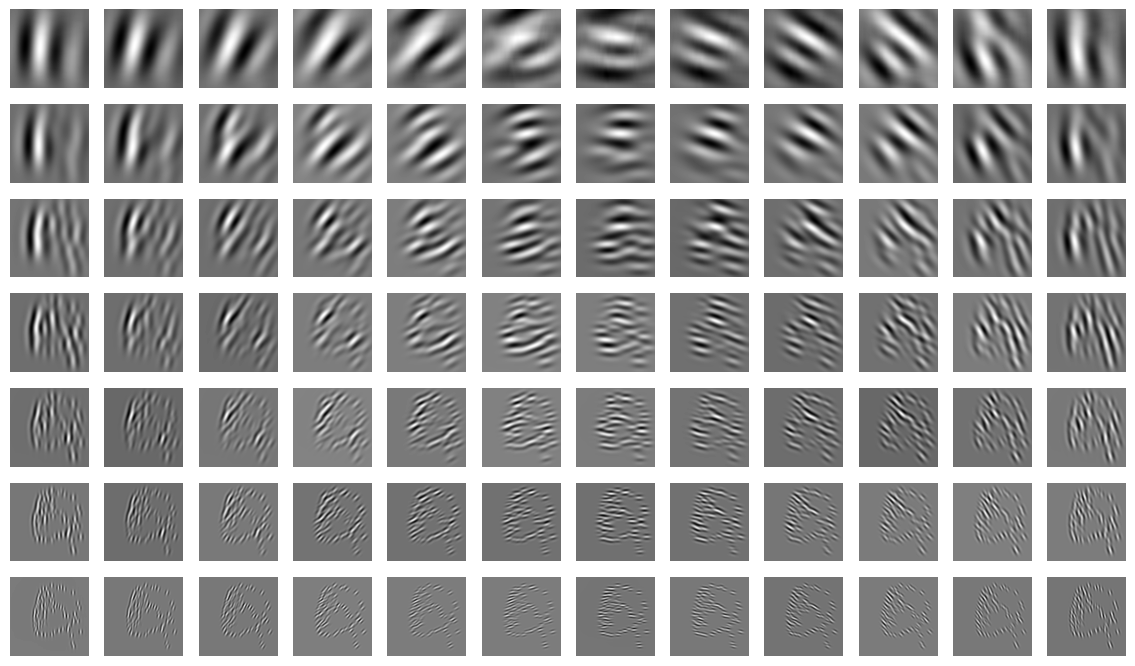

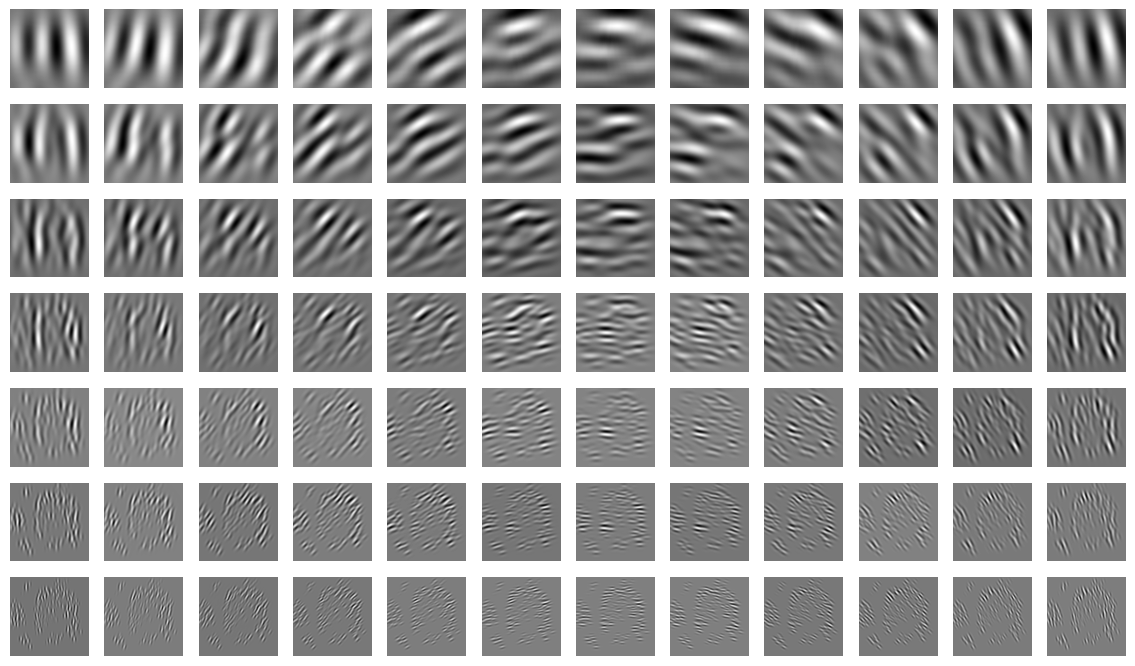

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_index = 5

grayscale_tensor = image_processing_dict[image_index]['grayscale']['stim']
contour_tensor = image_processing_dict[image_index]['contour']['stim'].squeeze(0)
LoG_tensor = image_processing_dict[image_index]['LoG_response']['stim'].max(0).values

grayscale_phosphenes = image_processing_dict[image_index]['grayscale']['phosphenes']
contour_phosphenes = image_processing_dict[image_index]['contour']['phosphenes']
LoG_phosphenes = image_processing_dict[image_index]['LoG_response']['phosphenes']

grayscale_gist = compute_gist_parallel(grayscale_tensor, device=device, plot_response=True, plot_kernels=True)
contour_gist   = compute_gist_parallel(contour_tensor, device=device, plot_response=True)
LoG_gist       = compute_gist_parallel(LoG_tensor, device=device, plot_response=True)

grayscale_phosphenes_gist = compute_gist_parallel(grayscale_phosphenes, device=device, plot_response=True)
contour_phosphenes_gist   = compute_gist_parallel(contour_phosphenes, device=device, plot_response=True)
LoG_phosphenes_gist       = compute_gist_parallel(LoG_phosphenes, device=device, plot_response=True)

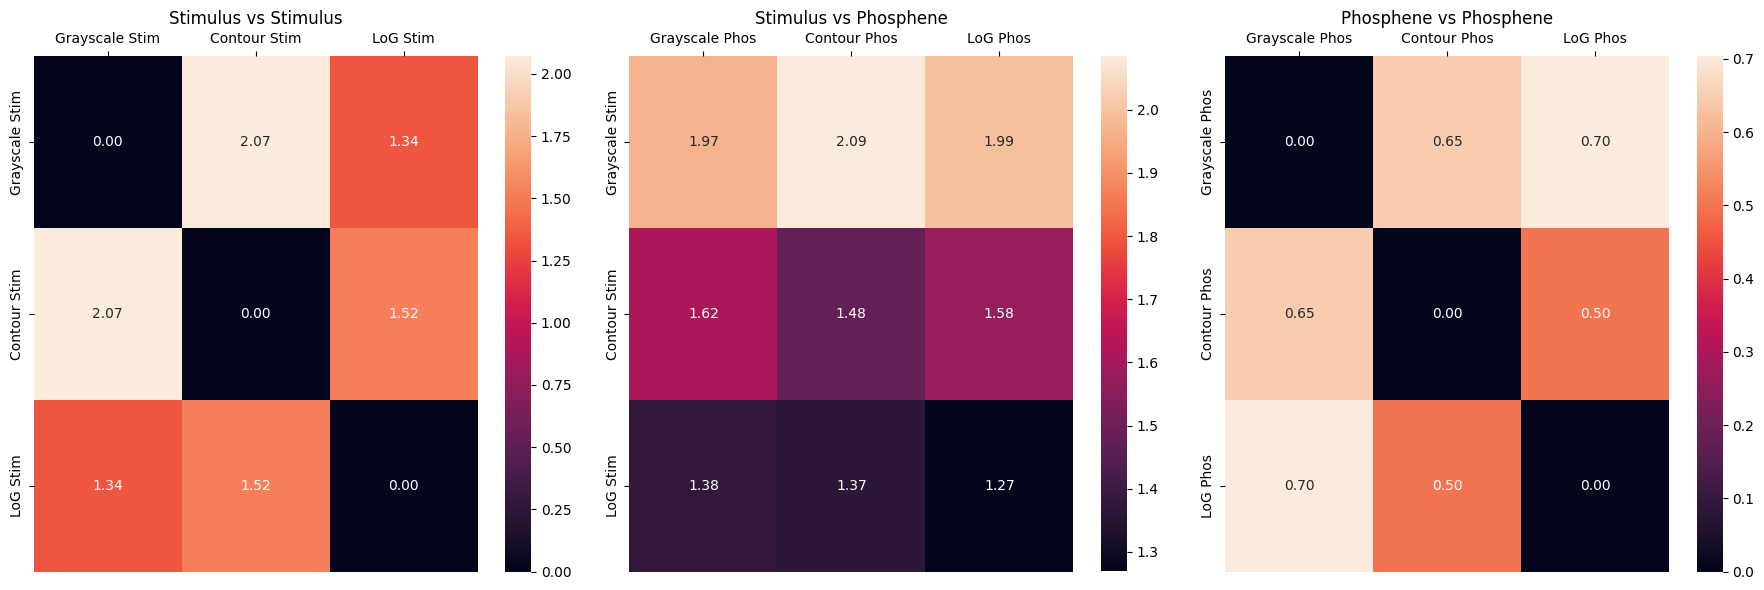

In [17]:
# 3 matrices: Stim vs Stim, Stim vs Phos, Phos vs Phos
stim_gist_vectors = [grayscale_gist, contour_gist, LoG_gist]
phos_gist_vectors = [grayscale_phosphenes_gist, contour_phosphenes_gist, LoG_phosphenes_gist]

# 1. Stimulus vs Stimulus (symmetric)
stim_stim_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(i, 3):
        swd_val = euclidean(stim_gist_vectors[i], stim_gist_vectors[j])
        stim_stim_matrix[i, j] = swd_val
        stim_stim_matrix[j, i] = swd_val  # symmetric

# 2. Phosphene vs Phosphene (symmetric)
phos_phos_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(i, 3):
        swd_val = euclidean(phos_gist_vectors[i], phos_gist_vectors[j])
        phos_phos_matrix[i, j] = swd_val
        phos_phos_matrix[j, i] = swd_val

# 3. Stimulus vs Phosphene (non-symmetric grouping: rows=stim, columns=phos)
stim_phos_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        stim_phos_matrix[i, j] = euclidean(stim_gist_vectors[i], phos_gist_vectors[j])

# Now plot three separate heatmaps.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Stimulus vs Stimulus heatmap
sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
            xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0])
axes[0].set_title("Stimulus vs Stimulus")
axes[0].xaxis.tick_top()

# Plot Stimulus vs Phosphene heatmap (full matrix)
sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
            xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1])
axes[1].set_title("Stimulus vs Phosphene")
axes[1].xaxis.tick_top()

# Plot Phosphene vs Phosphene heatmap
sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
            xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2])
axes[2].set_title("Phosphene vs Phosphene")
axes[2].xaxis.tick_top()

plt.tight_layout()

plt.show()

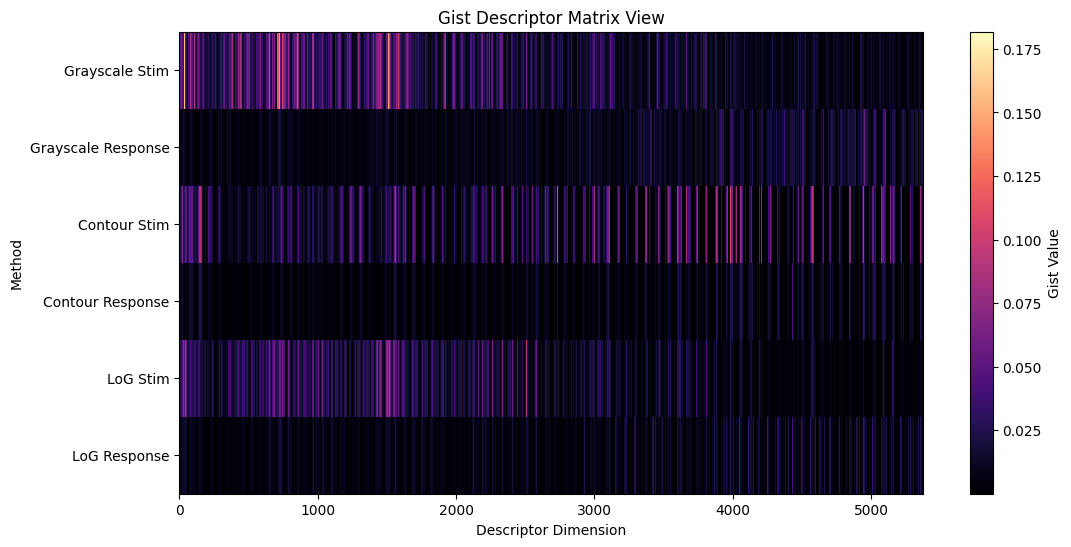

In [18]:
# Stack the gist vectors into a matrix of shape (6, D)
gist_matrix = torch.stack([grayscale_gist, grayscale_phosphenes_gist, contour_gist, contour_phosphenes_gist, LoG_gist, LoG_phosphenes_gist], dim=0).cpu()

# Define row labels for clarity
row_labels = [
    'Grayscale Stim', 
    'Grayscale Response',
    'Contour Stim', 
    'Contour Response',
    'LoG Stim', 
    'LoG Response'
]

# Create a figure to display the matrix as a heatmap.
plt.figure(figsize=(12, 6))
plt.imshow(gist_matrix, aspect='auto', cmap='magma', interpolation='None')
plt.colorbar(label='Gist Value')
plt.xlabel('Descriptor Dimension')
plt.ylabel('Method')
plt.yticks(
    ticks=np.arange(gist_matrix.shape[0]),
    labels=['Grayscale Stim', 'Grayscale Response', 'Contour Stim', 'Contour Response', 'LoG Stim', 'LoG Response']
)
plt.title('Gist Descriptor Matrix View')
plt.show()

# FSIM

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/fsim.py:290: UserWarning: median CUDA with indices output does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  median_e2n = torch.median(abs_eo ** 2, dim=-1, keepdim=True).values


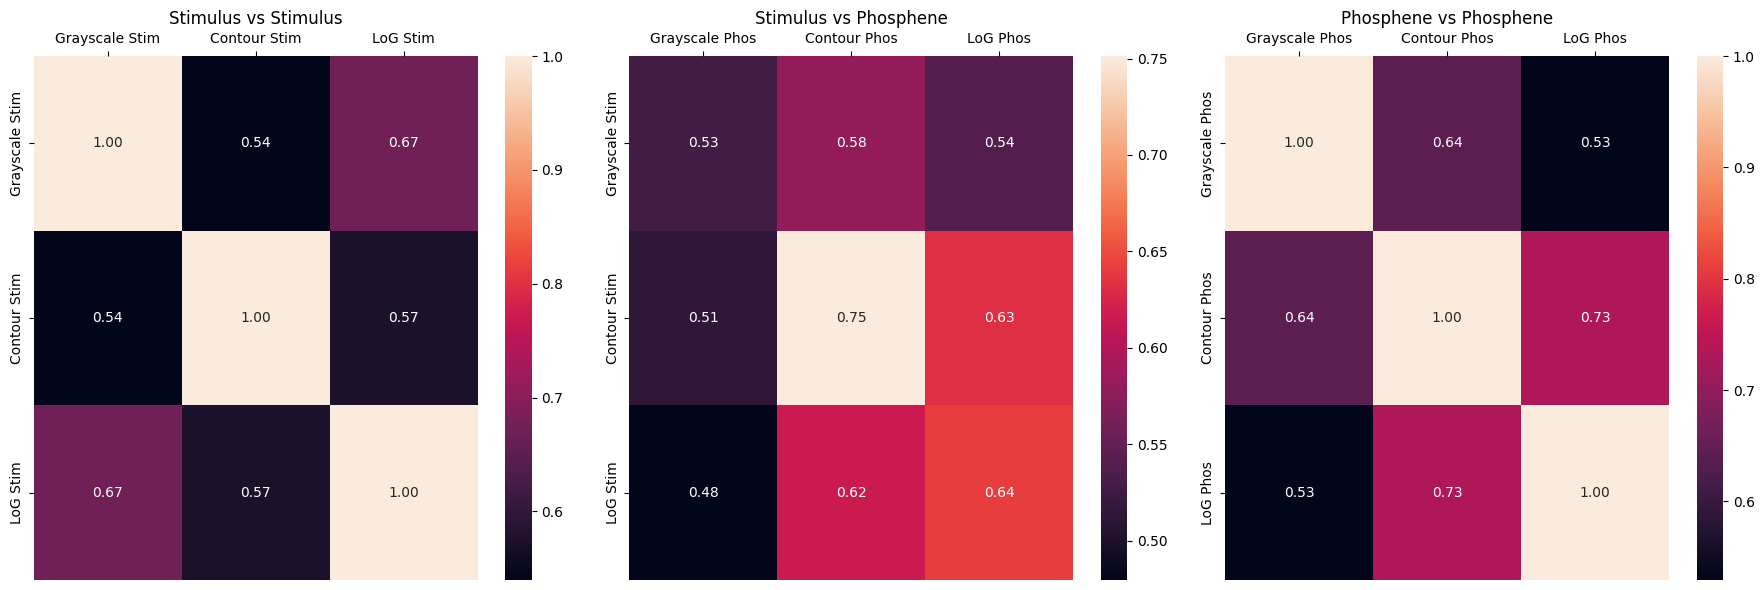

In [103]:
import piq

torch.use_deterministic_algorithms(True, warn_only=True)

grayscale_image = image_processing_dict[image_index]['grayscale']['stim'].unsqueeze(0).unsqueeze(0).detach()
contour_image = image_processing_dict[image_index]['contour']['stim'].unsqueeze(0).detach()
LoG_image = image_processing_dict[image_index]['LoG_response']['stim'].max(0).values.unsqueeze(0).unsqueeze(0).detach()

grayscale_response = image_processing_dict[image_index]['grayscale']['phosphenes'].unsqueeze(0).unsqueeze(0).detach()
contour_response = image_processing_dict[image_index]['contour']['phosphenes'].unsqueeze(0).unsqueeze(0).detach()
LoG_response = image_processing_dict[image_index]['LoG_response']['phosphenes'].unsqueeze(0).unsqueeze(0).detach()

stim_vectors = [grayscale_image, contour_image, LoG_image]
phos_vectors = [grayscale_response, contour_response, LoG_response]

# 1. Stimulus vs Stimulus (symmetric)
stim_stim_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(i, 3):
        fsim_val, _ = piq.fsim(stim_vectors[i], stim_vectors[j], data_range=1.0, chromatic=False, min_length=16)
        stim_stim_matrix[i, j] = fsim_val
        stim_stim_matrix[j, i] = fsim_val

# 2. Stimulus vs Phosphene (non-symmetric grouping: rows=stim, columns=phos)
stim_phos_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        fsim_val, _ = piq.fsim(stim_vectors[i], phos_vectors[j], data_range=1.0, chromatic=False, min_length=16)
        stim_phos_matrix[i, j] = fsim_val

# 3. Phosphene vs Phosphene (symmetric)
phos_phos_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(i, 3):
        fsim_val, _ = piq.fsim(phos_vectors[i], phos_vectors[j], data_range=1.0, chromatic=False, min_length=16)
        phos_phos_matrix[i, j] = fsim_val
        phos_phos_matrix[j, i] = fsim_val

# Now plot three separate heatmaps.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Stimulus vs Stimulus heatmap
sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
            xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0])
axes[0].set_title("Stimulus vs Stimulus")
axes[0].xaxis.tick_top()

# Plot Stimulus vs Phosphene heatmap (full matrix)
sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
            xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1])
axes[1].set_title("Stimulus vs Phosphene")
axes[1].xaxis.tick_top()

# Plot Phosphene vs Phosphene heatmap
sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
            xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2])
axes[2].set_title("Phosphene vs Phosphene")
axes[2].xaxis.tick_top()

plt.tight_layout()
plt.show()        

tensor(0.5807, device='cuda:0')


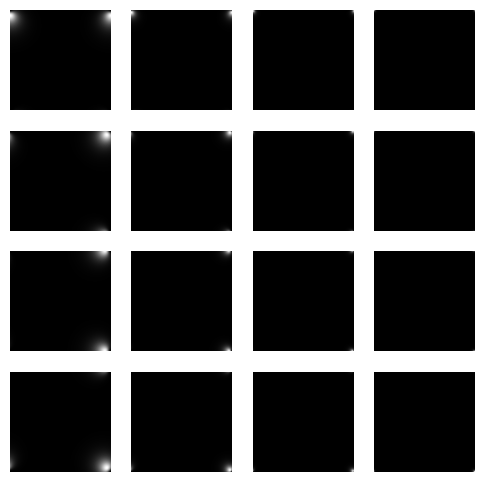

In [121]:
fsim_test, data = piq.fsim(grayscale_image, contour_response, data_range=1.0, chromatic=False, 
                           orientations=4, scales=4, min_length=16, mult=2, sigma_f=0.55)
print(fsim_test)
# show kernels with shape torch.Size([1, 16, 256, 256])
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(data['kernels'][0, i].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

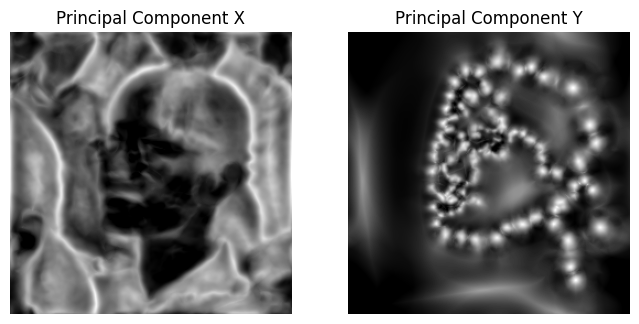

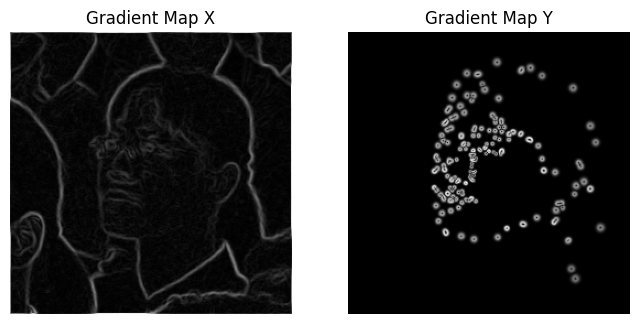

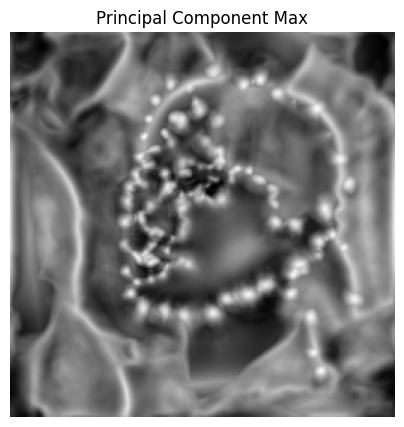

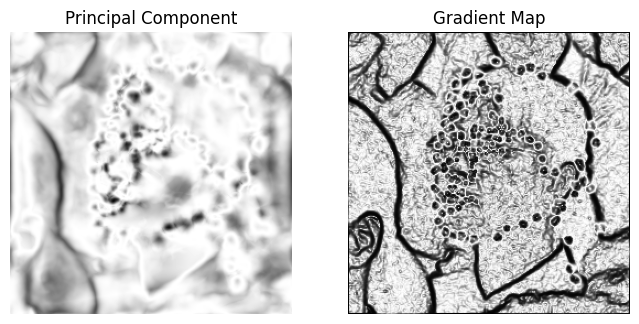

In [122]:
# show pc_x with shape torch.Size([1, 1, 256, 256]) and pc_y with shape torch.Size([1, 1, 256, 256])
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(data['pc_x'][0, 0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Principal Component X')

plt.subplot(1, 2, 2)
plt.imshow(data['pc_y'][0, 0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Principal Component Y')
plt.show()

# show 'grad_map_x' with shape torch.Size([1, 1, 256, 256]) and 'grad_map_y' with shape torch.Size([1, 1, 256, 256])
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(data['grad_map_x'][0, 0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Gradient Map X')

plt.subplot(1, 2, 2)
plt.imshow(data['grad_map_y'][0, 0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Gradient Map Y')
plt.show()

# plot pc_max with shape torch.Size([1, 1, 256, 256])

plt.figure(figsize=(5, 5))
plt.imshow(data['pc_max'][0, 0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Principal Component Max')
plt.show()

# plot data['PC'] and data['GM']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(data['PC'][0, 0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Principal Component')

plt.subplot(1, 2, 2)
plt.imshow(data['GM'][0, 0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Gradient Map')
plt.show()